In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
try:
    import faiss
except:
    pass

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

In [2]:
def plot_cm_subplots(cm_dict, suptitle=None):
    
    fig, axes = plt.subplots(1, len(cm_dict), figsize=(20, 5), sharey='row')
        
    for i, (key, cf_matrix) in enumerate(cm_dict.items()):
        disp = ConfusionMatrixDisplay(cf_matrix, display_labels=['Arrest','No Action'])
        disp.plot(ax=axes[i], xticks_rotation=45)
        disp.ax_.set_title(f'Confusion matrix for the {key} set')
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')
            
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    fig.colorbar(disp.im_, ax=axes)

    if len(cm_dict) % 2 != 0:
        j = int(np.floor(len(cm_dict)/2))
        ax_pos = axes[j].get_position()
        x_pos = (ax_pos.x0 + ax_pos.x1) / 2
    else:
        j = int((len(cm_dict) / 2) - 1)
        k = int(len(cm_dict) / 2)
        ax_pos_1 = axes[j].get_position()
        ax_pos_2 = axes[k].get_position()
        x_pos_1 = ax_pos_1.x1
        x_pos_2 = ax_pos_2.x0
        x_pos = (x_pos_1 + x_pos_2) / 2
            
    fig.text(x_pos, 0, 'Predicted label', ha='center')

    if suptitle != None:
        fig.text(x_pos, 0.95, suptitle, ha='center', fontsize=20)
    plt.show()

# Preprocessing

In [3]:
#read in data for preprocessing
data = pd.read_csv("NC_policing.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402087 entries, 0 to 402086
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   state               402087 non-null  object 
 1   stop_date           402087 non-null  object 
 2   driver_gender       402087 non-null  object 
 3   driver_age          401996 non-null  float64
 4   driver_race_raw     402087 non-null  object 
 5   driver_race         402087 non-null  object 
 6   violation           402087 non-null  object 
 7   search_type         402087 non-null  object 
 8   contraband_found    402087 non-null  bool   
 9   stop_outcome        402087 non-null  object 
 10  search_basis        402087 non-null  object 
 11  officer_id          402087 non-null  int64  
 12  drugs_related_stop  4379 non-null    object 
 13  district            402049 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(11)
memory usage: 40.3+ MB


In [4]:
#changing 'stop_date' feature to datetime in order to extract days of week
#as a feature. Instead of using "dates" we use "days of week"
#idea behind it: there can be a trend regarding occurances of arrest on
#specific days of week e.g. monday because it is first day of the week 
#and everyone is grumpy
data['stop_date'] = pd.to_datetime(data['stop_date'], errors = 'coerce')
data['stop_date:day_of_week'] = data['stop_date'].dt.day_of_week
data.head()

,state,stop_date,driver_gender,driver_age,driver_race_raw,driver_race,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week
0,NC,2000-07-31,M,23.0,W N,White,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3,0
1,NC,2000-07-31,F,29.0,W N,White,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3,0
2,NC,2000-07-31,F,49.0,B N,Black,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3,0
3,NC,2000-07-31,M,29.0,B N,Black,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3,0
4,NC,2000-07-31,M,24.0,U H,Hispanic,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3,0


In [4]:
#check number of NaN values in each column
data.isna().sum()

state                         0
stop_date                     0
driver_gender                 0
driver_age                   91
driver_race_raw               0
driver_race                   0
violation                     0
search_type                   0
contraband_found              0
stop_outcome                  0
search_basis                  0
officer_id                    0
drugs_related_stop       397708
district                     38
stop_date:day_of_week         0
dtype: int64

In [5]:
#fill missing values in "drivers_age" feature with mean of all values
age_fill = data['driver_age'].mean()
print("Average age:", age_fill)

#mean drivers age is 41.8, we round it to 42 since age can't be 
#looked at with decimal points
data['driver_age'] = data['driver_age'].fillna(int(np.rint(age_fill)))

#fill missing values in "drugs_related_stop" feature with false values
#since the probability of finding drugs in someone's car is low
data['drugs_related_stop'] = data['drugs_related_stop'].fillna(False)

#fill missing values in "district" feature with G7 district
#since its occurence in the feature column is the lowest and
#it won't have any significant effect
# data['district'] = data['district'].fillna('G7')
data.dropna(axis=0, inplace=True)

#check whether there are still missing values
data.isna().sum()

Average age: 41.878103264709104


state                    0
stop_date                0
driver_gender            0
driver_age               0
driver_race_raw          0
driver_race              0
violation                0
search_type              0
contraband_found         0
stop_outcome             0
search_basis             0
officer_id               0
drugs_related_stop       0
district                 0
stop_date:day_of_week    0
dtype: int64

In [6]:
#see which unique values do the columns of our dataset hold
for col in data:
    print(data[col].unique())

['NC']
['2000-07-31T00:00:00.000000000' '2000-08-01T00:00:00.000000000'
 '2000-08-02T00:00:00.000000000' ... '2015-12-29T00:00:00.000000000'
 '2015-12-30T00:00:00.000000000' '2015-12-31T00:00:00.000000000']
['M' 'F']
[23. 29. 49. 24. 21. 33. 16. 28. 39. 68. 20. 40. 50. 57. 38. 46. 34. 44.
 22. 36. 53. 32. 15. 27. 26. 41. 48. 25. 47. 42. 52. 17. 76. 61. 31. 30.
 64. 37. 19. 51. 18. 35. 59. 73. 43. 45. 66. 65. 54. 58. 55. 75. 63. 56.
 60. 81. 62. 77. 67. 69. 87. 70. 71. 78. 74. 85. 72. 79. 93. 80. 89. 82.
 84. 91. 83. 90. 88. 86. 92. 98. 99. 94. 96.]
['W N' 'B N' 'U H' 'W H' 'I N' 'U N' 'A N' 'A H' 'B H' 'I H']
['White' 'Black' 'Hispanic' 'Other' 'Asian']
['Speeding' 'DUI' 'Equipment' 'Seat belt' 'Other' 'Registration/plates'
 'Safe movement' 'Stop sign/light']
['No Search Conducted' 'Protective Frisk' 'Incident to Arrest' 'Consent'
 'Probable Cause' 'Warrant']
[False  True]
['Arrest' 'No Action']
['No Search Conducted' 'Observation Suspected Contraband'
 'Erratic Suspicious Behaviour' '

In [7]:
# After dropping some columns
data.head()

,state,stop_date,driver_gender,driver_age,driver_race_raw,driver_race,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week
0,NC,2000-07-31,M,23.0,W N,White,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,False,E3,0
1,NC,2000-07-31,F,29.0,W N,White,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,False,E3,0
2,NC,2000-07-31,F,49.0,B N,Black,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,False,E3,0
3,NC,2000-07-31,M,29.0,B N,Black,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,False,E3,0
4,NC,2000-07-31,M,24.0,U H,Hispanic,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,False,E3,0


In [8]:
#data['district'].value_counts()
#previous row shows the number of value-occurances in column

#since we can't work with string values for machine learning 
#we have to convert all non-numerical features to numerical ones
#especially features labeled as sensitive: gender, race, ...

#we drop the features not going to be used for ML
X = data.drop(columns=["state", "stop_date", "driver_race_raw", "stop_outcome"])
columns = X.columns
X

,driver_gender,driver_age,driver_race,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week
0,M,23.0,White,Speeding,No Search Conducted,False,No Search Conducted,10606,False,E3,0
1,F,29.0,White,Speeding,No Search Conducted,False,No Search Conducted,10606,False,E3,0
2,F,49.0,Black,Speeding,No Search Conducted,False,No Search Conducted,10606,False,E3,0
3,M,29.0,Black,Speeding,No Search Conducted,False,No Search Conducted,10606,False,E3,0
4,M,24.0,Hispanic,Speeding,No Search Conducted,False,No Search Conducted,10606,False,E3,0
...,...,...,...,...,...,...,...,...,...,...,...
402082,M,18.0,White,Speeding,Probable Cause,True,Observation Suspected Contraband,21715,True,G3,3
402083,F,21.0,Black,Registration/plates,Incident to Arrest,False,Other Official Info,10592,False,G5,3
402084,F,29.0,White,Speeding,Incident to Arrest,False,Observation Suspected Contraband,21848,False,E1,3
402085,F,18.0,White,Other,Probable Cause,True,Observation Suspected Contraband,11887,True,F5,3


In [9]:
#encode all features except driver's age, officer id and day of the week
le = LabelEncoder()

for col in X:
    if col=='driver_age' or col=='stop_date:day_of_week' or col=='driver_race':
        pass
    else:
        X[col] = le.fit_transform(X[col])

X.head()

,driver_gender,driver_age,driver_race,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week
0,1,23.0,White,6,2,0,18,722,0,34,0
1,0,29.0,White,6,2,0,18,722,0,34,0
2,0,49.0,Black,6,2,0,18,722,0,34,0
3,1,29.0,Black,6,2,0,18,722,0,34,0
4,1,24.0,Hispanic,6,2,0,18,722,0,34,0


In [10]:
tmp = X[['driver_race']]
tmp = pd.get_dummies(tmp)
X = X.drop(columns=['driver_race'])
X = pd.concat([X, tmp], axis=1)
X

,driver_gender,driver_age,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_Other,driver_race_White
0,1,23.0,6,2,0,18,722,0,34,0,0,0,0,0,1
1,0,29.0,6,2,0,18,722,0,34,0,0,0,0,0,1
2,0,49.0,6,2,0,18,722,0,34,0,0,1,0,0,0
3,1,29.0,6,2,0,18,722,0,34,0,0,1,0,0,0
4,1,24.0,6,2,0,18,722,0,34,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402082,1,18.0,6,3,1,19,2632,1,46,3,0,0,0,0,1
402083,0,21.0,3,1,0,25,711,0,48,3,0,1,0,0,0
402084,0,29.0,6,1,0,19,2738,0,32,3,0,0,0,0,1
402085,0,18.0,2,3,1,19,1873,1,43,3,0,0,0,0,1


In [11]:
#target variable y to classify arrest, encoded
y = data["stop_outcome"]
y_encoded = le.fit_transform(y)

#show coding
pd.DataFrame(data=le.transform(le.classes_),index=le.classes_,columns=["Coding"])

,Coding
Arrest,0
No Action,1


In [12]:
#for standard scaling later, we convert all data types to float32
X = X.astype(np.float32)

# Split the data into training and test set
# test_size=0.2: 60% training set, 20% test set, 20% CV
# random_state=350: fix the random set to get the same result every time you run the code (for tutorial purposes)
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=350)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.25, random_state=350)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(241229, 15)
(80410, 15)
(80410, 15)


### Standardizing the data

In [15]:
# Creating a scaler object (here with default settings)
scaler = StandardScaler()

# Replacing the values in our X_train by the normalized ones
X_train_norm = X_train.copy()
X_train_norm.values[:] = scaler.fit_transform(X_train)
# Replacing the values in our X_test by the normalized ones
X_test_norm = X_test.copy()
X_test_norm.values[:] = scaler.transform(X_test)
# Replacing the values in our X_val by the normalized ones
X_val_norm = X_test.copy()
X_val_norm.values[:] = scaler.transform(X_val)

X_train_norm

,driver_gender,driver_age,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_Other,driver_race_White
376090,0.323003,0.315311,-0.170781,0.180831,-0.130247,0.088705,0.049197,-0.104827,0.079392,0.641341,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
381498,0.323003,-0.222630,-0.170781,0.180831,-0.130247,0.088705,0.165899,-0.104827,0.807083,0.110470,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
155966,0.323003,-0.991118,-0.170781,0.180831,-0.130247,0.088705,1.038166,-0.104827,0.503878,-0.420400,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
148275,0.323003,-1.067967,-0.170781,0.180831,-0.130247,0.088705,-0.847009,-0.104827,0.140033,-0.420400,-0.066466,1.701267,-0.287442,-0.144067,-1.339623
344347,0.323003,-0.606874,-0.170781,0.180831,-0.130247,0.088705,0.613253,-0.104827,0.564519,1.703081,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340621,0.323003,-0.068933,-0.170781,0.180831,-0.130247,0.088705,0.435209,-0.104827,0.807083,-0.420400,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
106869,0.323003,-0.299479,-0.170781,0.180831,-0.130247,0.088705,0.786809,-0.104827,-0.284453,-1.482141,-0.066466,-0.587797,3.478958,-0.144067,-1.339623
92828,0.323003,-0.530026,-0.170781,0.180831,-0.130247,0.088705,-1.316806,-0.104827,0.867724,-0.951271,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
37632,0.323003,-1.144816,-0.170781,0.180831,-0.130247,0.088705,1.005250,-0.104827,1.110287,-0.951271,-0.066466,-0.587797,-0.287442,-0.144067,0.746479


# Plotting

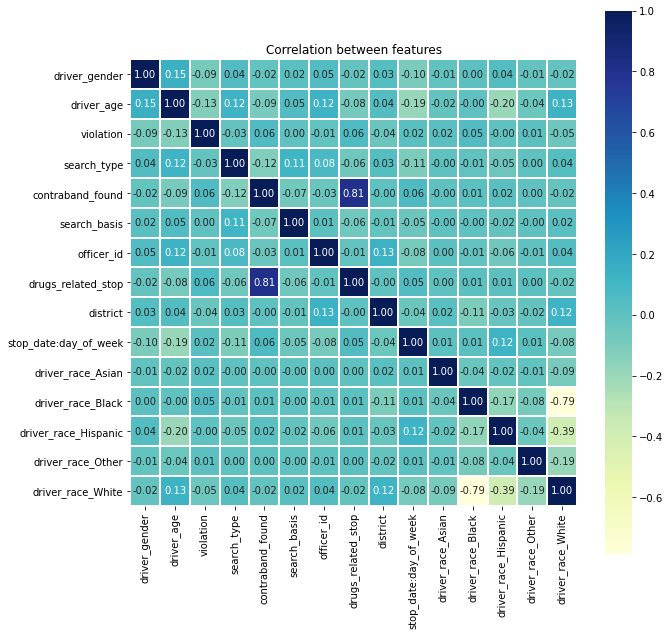

In [15]:
#creating correlation matrix for feature selection
corr = X.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, linewidths=0.1, square=True, annot=True, cmap='YlGnBu',
            linecolor="white", fmt='.2f')
plt.title('Correlation between features')
plt.show()

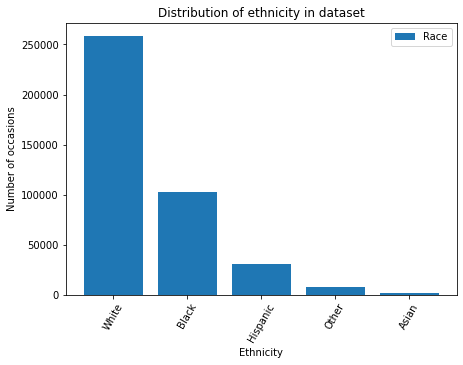

In [16]:
#representation of certain groups in the dataset
plt.figure(figsize=(7,5))
# Calculate the necessary number of bins for a better display
bins = np.arange(data['driver_race'].nunique()+1) - 0.5

plt.hist(data['driver_race'], bins=bins, rwidth=0.8, label='Race')
plt.xlabel('Ethnicity')
plt.ylabel('Number of occasions')
plt.title('Distribution of ethnicity in dataset')
plt.legend()
plt.xticks(rotation=60)
plt.show()

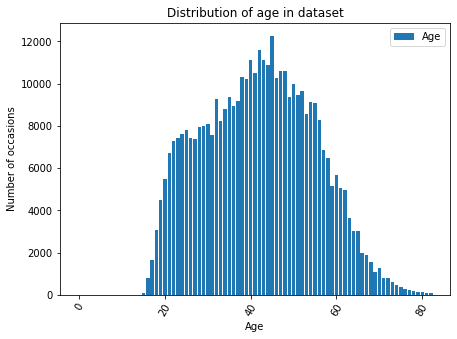

In [17]:
#representation of certain groups in the dataset
plt.figure(figsize=(7,5))
# Calculate the necessary number of bins for a better display
bins = np.arange(data['driver_age'].nunique()+1) - 0.5

plt.hist(data['driver_age'], bins=bins, rwidth=0.8, label='Age')
plt.xlabel('Age')
plt.ylabel('Number of occasions')
plt.title('Distribution of age in dataset')
plt.legend()
plt.xticks(rotation=60)
plt.show()

In [18]:
#number of arrestments among black and white people
data_race = data[['driver_race','stop_outcome']]
black_arr = data_race[data_race['driver_race']=='Black']
white_arr = data_race[data_race['driver_race']=='White']
hispanic_arr = data_race[data_race['driver_race']=='Hispanic']
asian_arr = data_race[data_race['driver_race']=='Asian']
other_arr = data_race[data_race['driver_race']=='Other']

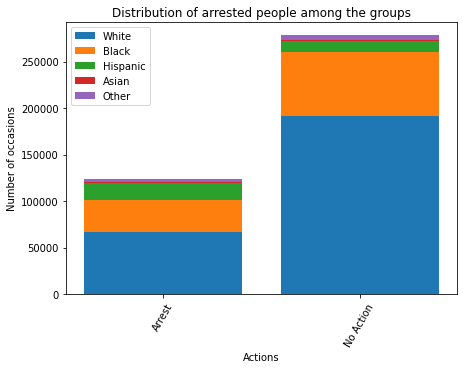

In [19]:
# Calculate the necessary number of bins for a better display
bins = np.arange(data_race['stop_outcome'].nunique()+1) - 0.5

plt.figure(figsize=(7,5))
# plt.hist([data_race['stop_outcome'], white_arr['stop_outcome'], black_arr['stop_outcome'], hispanic_arr['stop_outcome'], asian_arr['stop_outcome'], other_arr['stop_outcome']],
#          bins, label=['Overall','White','Black', 'Hispanic', 'Asian', 'Other'], rwidth=0.8, stacked=True)
plt.hist([white_arr['stop_outcome'], black_arr['stop_outcome'], hispanic_arr['stop_outcome'], asian_arr['stop_outcome'], other_arr['stop_outcome']],
         bins, label=['White','Black', 'Hispanic', 'Asian', 'Other'], rwidth=0.8, stacked=True)
plt.xlabel('Actions')
plt.ylabel('Number of occasions')
plt.title('Distribution of arrested people among the groups')
plt.legend(loc='upper left')
plt.xticks(rotation=60)
plt.show()

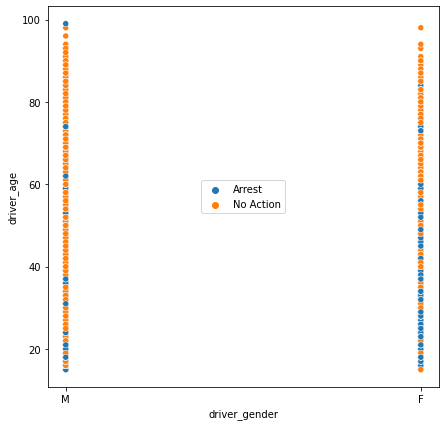

In [20]:
#scatter plot driver age against gender, frequency of arrestments
plt.figure(figsize=(7,7))
sns.scatterplot(x='driver_gender',y='driver_age',hue=data['stop_outcome'],data=data)
plt.legend(loc='center')
plt.show()

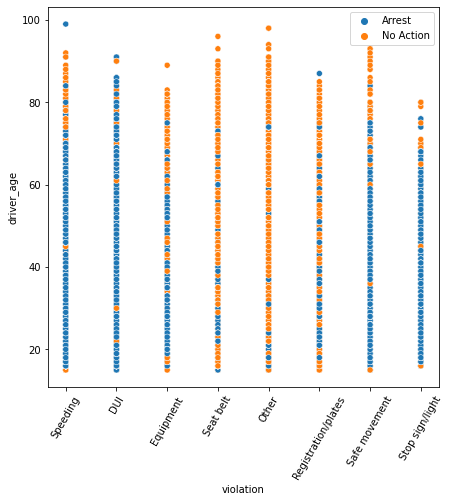

In [21]:
#scatter plot type of violation against driver age, frequency of arrestments
plt.figure(figsize=(7,7))
sns.scatterplot(x='violation',y='driver_age',hue=data['stop_outcome'],data=data)
plt.legend(loc='upper right')
plt.xticks(rotation=60)
plt.show()

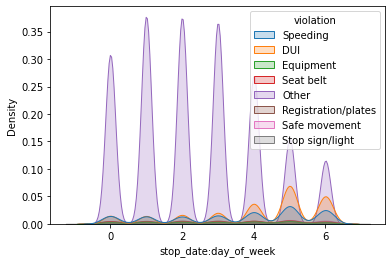

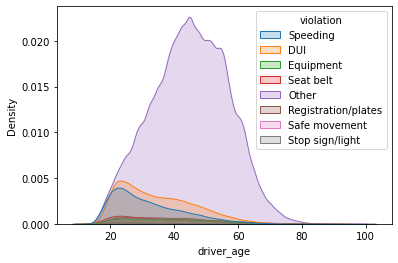

In [22]:
#kde to show on which day of the week does each type of
#violation occur the most
feat = data[['stop_date:day_of_week']]
for i,(column,color) in enumerate(zip(feat.columns,sns.color_palette())):
    plt.figure(i)
    sns.kdeplot(x=column,fill=True,hue=data.violation,data=data,color=color)
plt.show()
    
#kde to show the which type of violation mostly occurs
#by people of different ages
feat = data[['driver_age']]
for i,(column,color) in enumerate(zip(feat.columns,sns.color_palette())):
    plt.figure(i)
    sns.kdeplot(x=column,fill=True,hue=data.violation,data=data,color=color)
plt.show()

# Classifiers

Two types of classifiers are implemented

- K-Nearest Neighbors
- Neural Network

## k-NN Classifier

### Finding the optimal k-value

Defining the classifier using the faiss library for fast computation

In [17]:
# Use an external library from Facebook to speed up the computation
# Source: https://towardsdatascience.com/make-knn-300-times-faster-than-scikit-learns-in-20-lines-5e29d74e76bb
# git: https://github.com/facebookresearch/faiss/blob/master/INSTALL.md
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X)
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X, k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

Iterating over different k-values and testing the accuracy on the validation set

In [58]:
# List to store the accuracy scores
pred_score_knn_train = []
pred_score_knn_val = []
# k-values to try out
k_range = range(1, 21)

print("Entering loop")
# Iterate over all the k-values in the list
for i in k_range:
    print(f'k={i}')

    print("Created class")

    # Create an instance of sped up KNN with n_neighbors=i
    knn = FaissKNeighbors(k=i)
    print("Created an instance of KNN")

    # Train the model on the training set with the encoded labels
    # The classifier only accepts contiguous arrays
    tmp_train = np.ascontiguousarray(X_train_norm.to_numpy())
    knn.fit(tmp_train, y_train)
    print("Fitting complete")
    y_pred_train = knn.predict(tmp_train)
    print("Training prediction complete")
    
    # The classifier only accepts contiguous arrays
    tmp_val = np.ascontiguousarray(X_val_norm.to_numpy())
    y_pred_val = knn.predict(tmp_val)
    print("Validation prediction complete")

    # Append the accuracy scores to the list
    pred_score_knn_train.append(accuracy_score(y_train, y_pred_train))
    pred_score_knn_val.append(accuracy_score(y_val, y_pred_val))
    print("Accuracy score calculated")

    print()

Entering loop
k=1
Created class
Created an instance of KNN
Fitting complete
Training prediction complete
Validation prediction complete
Accuracy score calculated

k=2
Created class
Created an instance of KNN
Fitting complete
Training prediction complete
Validation prediction complete
Accuracy score calculated

k=3
Created class
Created an instance of KNN
Fitting complete
Training prediction complete
Validation prediction complete
Accuracy score calculated

k=4
Created class
Created an instance of KNN
Fitting complete
Training prediction complete
Validation prediction complete
Accuracy score calculated

k=5
Created class
Created an instance of KNN
Fitting complete
Training prediction complete
Validation prediction complete
Accuracy score calculated

k=6
Created class
Created an instance of KNN
Fitting complete
Training prediction complete
Validation prediction complete
Accuracy score calculated

k=7
Created class
Created an instance of KNN
Fitting complete
Training prediction complete
V

In [82]:
# Save the accuracy scores
# pickle.dump(pred_score_knn_train, open('pred_score_knn_train.sav', 'wb'))
# pickle.dump(pred_score_knn_val, open('pred_score_knn_val.sav', 'wb'))

Plot the pre-computed result

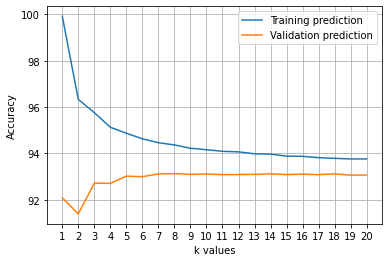

In [85]:
# Range of k-values for plotting purposes
k_range = range(1, 21)
# Load the pre-computed pred_score
pred_score_knn_train = pickle.load(open('pred_score_knn_train.sav', 'rb'))
pred_score_knn_val = pickle.load(open('pred_score_knn_val.sav', 'rb'))
# Convert the list to an array and multiply with 100 to get percentages
pred_score_knn_train = np.array(pred_score_knn_train) * 100
pred_score_knn_val = np.array(pred_score_knn_val) * 100
# Plot the results
plt.plot(k_range, pred_score_knn_train, label='Training prediction')
plt.plot(k_range, pred_score_knn_val, label='Validation prediction')
plt.xlabel("k values")
plt.ylabel("Accuracy")
plt.xticks(k_range)
plt.legend()
plt.grid()
plt.show()

### Measuring k-NN Classifier Performance

Pick k = 5 and train the standard classifier from scikit-learn 

#### Scikit-Learn

In [26]:
# Load the pre-computed results
knn_sklearn = pickle.load(open('knn_sklearn.sav', 'rb'))
y_pred_train_knn_sklearn = pickle.load(open('y_pred_train_knn_sklearn.sav', 'rb'))
y_pred_val_knn_sklearn = pickle.load(open('y_pred_val_knn_sklearn.sav', 'rb'))
y_pred_test_knn_sklearn = pickle.load(open('y_pred_test_knn_sklearn.sav', 'rb'))

In [30]:
# Create an instance of KNN with n_neighbors=5
knn_sklearn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
print("Created an instance of KNN")

Created an instance of KNN


In [31]:
# Train the model on the training set with the encoded labels
knn_sklearn.fit(X_train_norm, y_train)
print("Fitting complete")

Fitting complete


In [32]:
#Predictions for training, validation and test set

y_pred_train_knn_sklearn = knn_sklearn.predict(X_train_norm)
print("Training prediction complete")

y_pred_val_knn_sklearn = knn_sklearn.predict(X_val_norm)
print("Validation prediction complete")

y_pred_test_knn_sklearn = knn_sklearn.predict(X_test_norm)
print("Test prediction complete")

Training prediction complete
Validation prediction complete
Test prediction complete


In [ ]:
# Save the classifier and the variables to disk
# pickle.dump(knn_sklearn, open('knn_sklearn.sav', 'wb'))
# pickle.dump(y_pred_train_knn_sklearn, open('y_pred_train_knn_sklearn.sav', 'wb'))
# pickle.dump(y_pred_val_knn_sklearn, open('y_pred_val_knn_sklearn.sav', 'wb'))
# pickle.dump(y_pred_test_knn_sklearn, open('y_pred_test_knn_sklearn.sav', 'wb'))

Plotting the confusion matrices

In [ ]:
cm_train_knn_sklearn = confusion_matrix(y_train, y_pred_train_knn_sklearn)
cm_val_knn_sklearn = confusion_matrix(y_val, y_pred_val_knn_sklearn)
cm_test_knn_sklearn = confusion_matrix(y_test, y_pred_test_knn_sklearn)

In [ ]:
tmp_dict = {'training': cm_train_knn_sklearn, 'validation': cm_val_knn_sklearn, 'test': cm_test_knn_sklearn}
plot_cm_subplots(tmp_dict, 'kNN classifier')

#### Faiss

The same thing for faiss

In [24]:
# Run faiss initalization first
knn_faiss = pickle.load(open('knn_faiss.sav', 'rb'))
y_pred_train_knn_faiss = pickle.load(open('y_pred_train_knn_faiss.sav', 'rb'))
y_pred_val_knn_faiss = pickle.load(open('y_pred_val_knn_faiss.sav', 'rb'))
y_pred_test_knn_faiss = pickle.load(open('y_pred_test_knn_faiss.sav', 'rb'))

Fitting and prediction for k-NN from faiss

In [ ]:
knn_faiss = FaissKNeighbors(k=5) #not interpreted as classifier by plotting functions
print("Created an instance of KNN")

tmp_train = np.ascontiguousarray(X_train_norm.to_numpy())
knn_faiss.fit(tmp_train, y_train)
print("Fitting complete")

y_pred_train_knn_faiss = knn_faiss.predict(tmp_train)
print("Training prediction complete")

tmp_val = np.ascontiguousarray(X_val_norm.to_numpy())
y_pred_val_knn_faiss = knn_faiss.predict(tmp_val)
print("Validation prediction complete")

tmp_test = np.ascontiguousarray(X_test_norm.to_numpy())
y_pred_test_knn_faiss = knn_faiss.predict(tmp_test)
print("Test prediction complete")

In [ ]:
# Save the classifier and the variables to disk
# pickle.dump(knn_faiss, open('knn_faiss.sav', 'wb'))
# pickle.dump(y_pred_train_knn_faiss, open('y_pred_train_knn_faiss.sav', 'wb'))
# pickle.dump(y_pred_val_knn_faiss, open('y_pred_val_knn_faiss.sav', 'wb'))
# pickle.dump(y_pred_test_knn_faiss, open('y_pred_test_knn_faiss.sav', 'wb'))

### Dummy Classifier

In [31]:
# Create an array with the length of y_test that always has the value 0 (Arrest)
y_train_dummy = np.zeros(len(y_train))
y_val_dummy = np.zeros(len(y_val))
y_test_dummy = np.zeros(len(y_test))

Accuracy on training set: 0.307264


<Figure size 432x288 with 0 Axes>

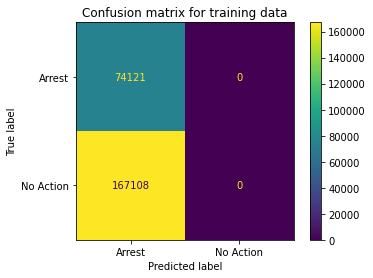

Accuracy on training set: 0.309937


<Figure size 432x288 with 0 Axes>

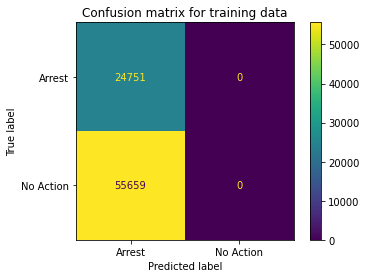

Accuracy on test set: 0.307810


<Figure size 432x288 with 0 Axes>

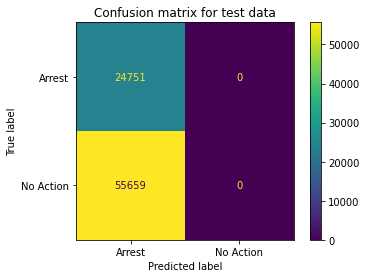

In [32]:
#Measuring Accuracy Score

cm_train_dummy = confusion_matrix(y_train, y_train_dummy)
cm_val_dummy = confusion_matrix(y_test, y_val_dummy)
cm_test_dummy = confusion_matrix(y_test, y_test_dummy)

print("Accuracy on training set: %f" %accuracy_score(y_train, y_train_dummy))
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train_dummy, display_labels=['Arrest','No Action'])
disp.plot()
plt.grid(False)
plt.title("Confusion matrix for training data")
plt.show()

print("Accuracy on training set: %f" %accuracy_score(y_val, y_val_dummy))
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_dummy, display_labels=['Arrest','No Action'])
disp.plot()
plt.grid(False)
plt.title("Confusion matrix for training data")
plt.show()

print("Accuracy on test set: %f" % accuracy_score(y_test, y_test_dummy))
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_dummy, display_labels=['Arrest','No Action'])
disp.plot()
plt.grid(False)
plt.title("Confusion matrix for test data")
plt.show()

## Neural Network

### Finding the optimal number of hidden units

In [121]:
# List to store the accuracy scores
pred_score_nn_train = []
pred_score_nn_val = []
# k-values to try out
num_hids_range = np.arange(5, 205, 5)

print("Entering loop")
# Iterate over all the k-values in the list
for i in num_hids_range:
    print(f'k={i}')

    # Create an instance of NN with hidden_layer_sizes=(i,)
    nn_sklearn = MLPClassifier(solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(i,), random_state=1, max_iter=1000)
    print("Created an instance of NN")

    # Train the model on the training set with the encoded labels
    nn_sklearn.fit(X_train_norm, y_train)
    print("Fitting complete")
    
    # Make predictions on the training set
    y_pred_train_nn_sklearn = nn_sklearn.predict(X_train_norm)
    print("Training prediction complete")
    
    # Make predictions on the validation set
    y_pred_val_nn_sklearn = nn_sklearn.predict(X_val_norm)
    print("Validation prediction complete")

    # Append the accuracy scores to the list
    pred_score_nn_train.append(accuracy_score(y_train, y_pred_train_nn_sklearn))
    print("Training accuracy score calculated")
    pred_score_nn_val.append(accuracy_score(y_val, y_pred_val_nn_sklearn))
    print("Validation accuracy score calculated")

    print()

Entering loop
k=105
Created an instance of NN
Fitting complete
Training prediction complete
Validation prediction complete
Training accuracy score calculated
Validation accuracy score calculated

k=110
Created an instance of NN
Fitting complete
Training prediction complete
Validation prediction complete
Training accuracy score calculated
Validation accuracy score calculated

k=115
Created an instance of NN
Fitting complete
Training prediction complete
Validation prediction complete
Training accuracy score calculated
Validation accuracy score calculated

k=120
Created an instance of NN
Fitting complete
Training prediction complete
Validation prediction complete
Training accuracy score calculated
Validation accuracy score calculated

k=125
Created an instance of NN
Fitting complete
Training prediction complete
Validation prediction complete
Training accuracy score calculated
Validation accuracy score calculated

k=130
Created an instance of NN
Fitting complete
Training prediction complet

In [156]:
# Save the accuracy scores
# pickle.dump(pred_score_nn_train, open('pred_score_nn_train.sav', 'wb'))
# pickle.dump(pred_score_nn_val, open('pred_score_nn_val.sav', 'wb'))

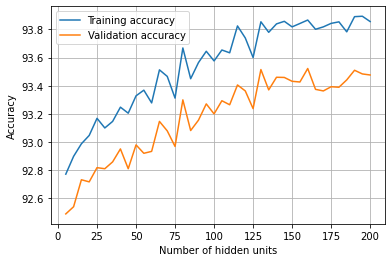

In [158]:
# Range of k-values for plotting purposes
num_hids_range = np.arange(5, 205, 5)
# Load the pre-computed pred_score
pred_score_nn_train = pickle.load(open('pred_score_nn_train.sav', 'rb'))
pred_score_nn_val = pickle.load(open('pred_score_nn_val.sav', 'rb'))
# Convert the list to an array and multiply with 100 to get percentages
pred_score_nn_train = np.array(pred_score_nn_train) * 100
pred_score_nn_val = np.array(pred_score_nn_val) * 100
# Plot the results
plt.plot(num_hids_range, pred_score_nn_train, label='Training accuracy')
plt.plot(num_hids_range, pred_score_nn_val, label='Validation accuracy')
plt.xlabel("Number of hidden units")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [163]:
pred_score_nn_train

array([92.77201332, 92.89844919, 92.98757612, 93.04685589, 93.16831724,
       93.09991751, 93.14634642, 93.24749512, 93.2047971 , 93.32791663,
       93.36812738, 93.27775682, 93.51238864, 93.46595973, 93.31174942,
       93.66784259, 93.44937798, 93.56379208, 93.64421359, 93.57581385,
       93.65333355, 93.63343545, 93.82412562, 93.73872959, 93.5998574 ,
       93.85355824, 93.77894034, 93.83863466, 93.85687459, 93.81749292,
       93.84153647, 93.86599455, 93.80049662, 93.81749292, 93.84236555,
       93.85314369, 93.78225669, 93.8900381 , 93.8929399 , 93.85521641])

### Measuring NN performance


In [ ]:
nn_sklearn = pickle.load(open('nn_sklearn.sav', 'rb'))
y_pred_train_nn_sklearn = pickle.load(open('y_pred_train_nn_sklearn.sav', 'rb'))
y_pred_val_nn_sklearn = pickle.load(open('y_pred_val_nn_sklearn.sav', 'rb'))
y_pred_test_nn_sklearn = pickle.load(open('y_pred_test_nn_sklearn.sav', 'rb'))

In [168]:
nn_sklearn = MLPClassifier(solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(20,), random_state=1, max_iter=1000)

In [169]:
nn_sklearn.fit(X_train_norm, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(20,), max_iter=1000,
              random_state=1)

In [170]:
y_pred_train_nn_sklearn = nn_sklearn.predict(X_train_norm)
print("Training prediction complete")
y_pred_val_nn_sklearn = nn_sklearn.predict(X_val_norm)
print("Validation prediction complete")
y_pred_test_nn_sklearn = nn_sklearn.predict(X_test_norm)
print("Test prediction complete")

Training prediction complete
Validation prediction complete
Test prediction complete


In [171]:
# Save the classifier to disk
# pickle.dump(nn_sklearn, open('nn_sklearn.sav', 'wb'))
# pickle.dump(y_pred_train_nn_sklearn, open('y_pred_train_nn_sklearn.sav', 'wb'))
# pickle.dump(y_pred_val_nn_sklearn, open('y_pred_val_nn_sklearn.sav', 'wb'))
# pickle.dump(y_pred_test_nn_sklearn, open('y_pred_test_nn_sklearn.sav', 'wb'))

WITH EPOCHS VISUALIZATION

In [42]:
#input shape = 121 because X has 121 columns

model = tf.keras.Sequential([
    tf.keras.layers.Dense(7, input_shape=(15,), activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [43]:
hiddens_range = range(1,15)

for num_hiddens in hiddens_range:
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_hiddens, input_shape=(15,), activation='relu'), 
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='nadam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
    model.summary()
    tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 16        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 32        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3        

Compile the model by choosing an optimizer, a loss and a metric for evaluation.

Now, train the model for 10 epochs and evaluate it simultaneously.

In [44]:
history = model.fit(X_train_norm, y_train, epochs=10, validation_split=0.3)

Epoch 1/10
5277/5277 [==============================] - 21s 4ms/step - loss: 0.2353 - accuracy: 0.9102 - val_loss: 0.1929 - val_accuracy: 0.9272
Epoch 2/10
5277/5277 [==============================] - 20s 4ms/step - loss: 0.1928 - accuracy: 0.9271 - val_loss: 0.1907 - val_accuracy: 0.9269
Epoch 3/10
5277/5277 [==============================] - 19s 4ms/step - loss: 0.1910 - accuracy: 0.9270 - val_loss: 0.1888 - val_accuracy: 0.9281
Epoch 4/10
5277/5277 [==============================] - 20s 4ms/step - loss: 0.1895 - accuracy: 0.9276 - val_loss: 0.1881 - val_accuracy: 0.9282
Epoch 5/10
5277/5277 [==============================] - 13s 2ms/step - loss: 0.1884 - accuracy: 0.9279 - val_loss: 0.1868 - val_accuracy: 0.9284
Epoch 6/10
5277/5277 [==============================] - 16s 3ms/step - loss: 0.1877 - accuracy: 0.9280 - val_loss: 0.1860 - val_accuracy: 0.9283
Epoch 7/10
5277/5277 [==============================] - 20s 4ms/step - loss: 0.1870 - accuracy: 0.9281 - val_loss: 0.1852 - val_ac

In [45]:
model.evaluate(X_val_norm,  y_val)

2513/2513 [==============================] - 6s 2ms/step - loss: 0.1906 - accuracy: 0.9256


[0.19057807326316833, 0.9256435632705688]

Prediction and Confusion Matrices for Training, Validation and Test Set 

In [46]:
y_pred_train_nn_tf = model.predict(X_train_norm)>=0.5
y_pred_val_nn_tf = model.predict(X_val_norm)>=0.5
y_pred_test_nn_tf = model.predict(X_test_norm)>=0.5

cm_train_nn_tf = confusion_matrix(y_train, y_pred_train_nn_tf)
cm_val_nn_tf = confusion_matrix(y_val, y_pred_val_nn_tf)
cm_test_nn_tf = confusion_matrix(y_test, y_pred_test_nn_tf)

Metrics for accuracy of the model and plotting the confusion matrices for training, validation and test set

Accuracy on training set: 0.928520
Accuracy on validation set: 0.925644
Accuracy on test set: 0.927347


<Figure size 432x288 with 0 Axes>

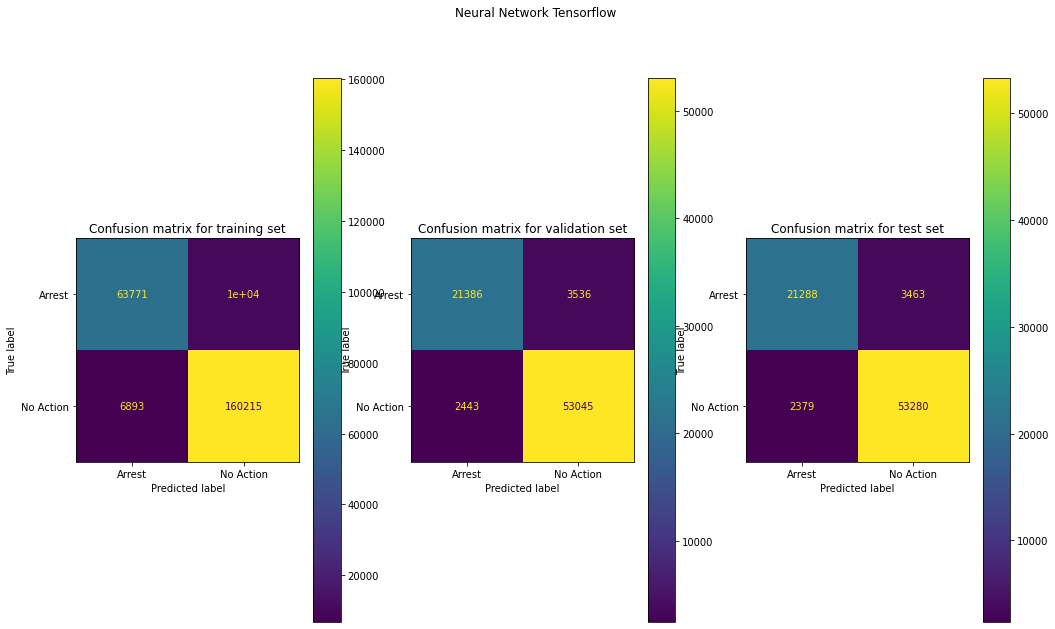

In [47]:
print("Accuracy on training set: %f" %accuracy_score(y_train, y_pred_train_nn_tf))
print("Accuracy on validation set: %f" %accuracy_score(y_val, y_pred_val_nn_tf))
print("Accuracy on test set: %f" %accuracy_score(y_test, y_pred_test_nn_tf))
plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17,10))
fig.suptitle('Neural Network Tensorflow')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train_nn_tf, display_labels=le.classes_)
disp.plot(ax=ax1)
ax1.set_title("Confusion matrix for training set")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_nn_tf, display_labels=le.classes_)
disp.plot(ax=ax2)
ax2.set_title("Confusion matrix for validation set")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_nn_tf, display_labels=le.classes_)
disp.plot(ax=ax3)
ax3.set_title("Confusion matrix for test set")

plt.grid(False)

plt.show()

Plotting the accuracys over the epochs.

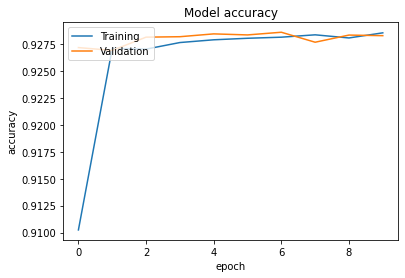

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

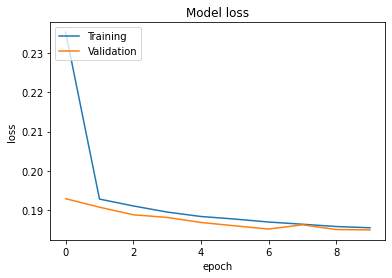

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [ ]:
train_sizes_knn, train_scores_knn, test_scores_knn, fit_times_knn, _ = \
    learning_curve(knn_sklearn, X_train_norm, y_train, n_jobs=-1,
                   return_times=True)

In [ ]:
pickle.dump(train_sizes_knn, open('train_sizes_knn.sav', 'wb'))
pickle.dump(train_scores_knn, open('train_scores_knn.sav', 'wb'))
pickle.dump(test_scores_knn, open('test_scores_knn.sav', 'wb'))
pickle.dump(fit_times_knn, open('fit_times_knn.sav', 'wb'))

In [ ]:
train_sizes_knn = pickle.load(open('train_sizes_knn.sav', 'rb'))
train_scores_knn = pickle.load(open('train_scores_knn.sav', 'rb'))
test_scores_knn = pickle.load(open('test_scores_knn.sav', 'rb'))
fit_times_knn = pickle.load(open('fit_times_knn.sav', 'rb'))

In [ ]:
train_scores_mean_knn = np.mean(train_scores_knn, axis=1)
train_scores_std_knn = np.std(train_scores_knn, axis=1)
test_scores_mean_knn = np.mean(test_scores_knn, axis=1)
test_scores_std_knn = np.std(test_scores_knn, axis=1)
fit_times_mean_knn = np.mean(fit_times_knn, axis=1)
fit_times_std_knn = np.std(fit_times_knn, axis=1)

# Plot learning curve
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.xlim()
plt.fill_between(train_sizes_knn, train_scores_mean_knn - train_scores_std_knn,
                     train_scores_mean_knn + train_scores_std_knn, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes_knn, test_scores_mean_knn - test_scores_std_knn,
                     test_scores_mean_knn + test_scores_std_knn, alpha=0.1,
                     color="g")
plt.plot(train_sizes_knn, train_scores_mean_knn, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes_knn, test_scores_mean_knn, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [ ]:
train_sizes_nn, train_scores_nn, test_scores_nn, fit_times_nn, _ = \
    learning_curve(nn_sklearn, X_train_norm, y_train, n_jobs=-1,
                   return_times=True)

In [ ]:
pickle.dump(train_sizes_nn, open('train_sizes_nn.sav', 'wb'))
pickle.dump(train_scores_nn, open('train_scores_nn.sav', 'wb'))
pickle.dump(test_scores_nn, open('test_scores_nn.sav', 'wb'))
pickle.dump(fit_times_nn, open('fit_times_nn.sav', 'wb'))

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

# Plot learning curve
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.xlim()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.show()

### Independence, Seperation and Sufficiency

In [ ]:
def independence(tn, fp, fn, tp):
    # change the calculation of output
    output = (tp + fp) / (tn + fp + fn + tp)
    return output

In [ ]:
def separation(tn, fp, fn, tp):
    # change the calculation of the seperation for the two conditions Y_1 and Y_0
    Y_1 = tp / (tp + fp)
    Y_0 = tn / (tn + fn)
    return Y_1, Y_0

In [ ]:
def sufficiency(tn, fp, fn, tp):
    # change the calculation of the seperation for the two conditions R_1 and R_0
    R_1 = tp / (tp + fn)
    R_0 = fp / (fp + tn)
    return R_1, R_0

#### Race groups


using the knn classifier

In [ ]:
group_asian = X_test['driver_race_Asian'] == 1
group_black = X_test['driver_race_Black'] == 1
group_white = X_test['driver_race_White'] == 1
group_hispanic = X_test['driver_race_Hispanic'] == 1
group_other = X_test['driver_race_Other'] == 1

y_pred_asian = y_pred[group_asian]
y_test_asian = y_test[group_asian]
X_test_asian = X_test[group_asian]

y_pred_black = y_pred[group_black]
y_test_black = y_test[group_black]
X_test_black = X_test[group_black]

y_pred_white = y_pred[group_white]
y_test_white = y_test[group_white]
X_test_white = X_test[group_white]

y_pred_hispanic = y_pred[group_hispanic]
y_test_hispanic = y_test[group_hispanic]
X_test_hispanic = X_test[group_hispanic]

y_pred_other = y_pred[group_other]
y_test_other = y_test[group_other]
X_test_other = X_test[group_other]

In [ ]:
cm_asian = confusion_matrix(y_test_asian, y_pred_asian)
cm_black = confusion_matrix(y_test_black, y_pred_black)
cm_white = confusion_matrix(y_test_white, y_pred_white)
cm_hispanic = confusion_matrix(y_test_hispanic, y_pred_hispanic)
cm_other = confusion_matrix(y_test_other, y_pred_other)

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize = (14,17))
ax6.axis('off')
fig.suptitle('Confusion Matrices for different Race Groups')

plot_confusion_matrix(knn, X_test_asian, y_test_asian, display_labels=le.classes_, ax=ax1)
ax1.set_title('Race Group: Asian')
plot_confusion_matrix(knn, X_test_black, y_test_black, display_labels=le.classes_, ax=ax2)
ax2.set_title('Race Group: Black')
plot_confusion_matrix(knn, X_test_white, y_test_white, display_labels=le.classes_, ax=ax3)
ax3.set_title('Race Group: White')
plot_confusion_matrix(knn, X_test_hispanic, y_test_hispanic, display_labels=le.classes_, ax=ax4)
ax4.set_title('Race Group: Hispanic')
plot_confusion_matrix(knn, X_test_other, y_test_other, display_labels=le.classes_, ax=ax5)
ax5.set_title('Race Group: Other')

In [ ]:
tn_asian, fp_asian, fn_asian, tp_asian = confusion_matrix(y_test_asian, y_pred_asian).ravel()
tn_black, fp_black, fn_black, tp_black = confusion_matrix(y_test_black, y_pred_black).ravel()
tn_white, fp_white, fn_white, tp_white = confusion_matrix(y_test_white, y_pred_white).ravel()
tn_hispanic, fp_hispanic, fn_hispanic, tp_hispanic = confusion_matrix(y_test_hispanic, y_pred_hispanic).ravel()
tn_other, fp_other, fn_other, tp_other = confusion_matrix(y_test_other, y_pred_other).ravel()

In [ ]:
ind_asian = independence(tn_asian, fp_asian, fn_asian, tp_asian)
ind_black = independence(tn_black, fp_black, fn_black, tp_black)
ind_white = independence(tn_white, fp_white, fn_white, tp_white)
ind_hispanic = independence(tn_hispanic, fp_hispanic, fn_hispanic, tp_hispanic)
ind_other = independence(tn_other, fp_other, fn_other, tp_other)

In [ ]:
print(ind_asian, ind_black, ind_white, ind_hispanic, ind_other)
#hispanics are less likely to be classified as not-arrested than white people.

In [ ]:
diff_asian_white_ind = abs(ind_asian - ind_white)
diff_black_white_ind = abs(ind_black - ind_white)
diff_hispanic_white_ind = abs(ind_hispanic - ind_white)
diff_other_white_ind = abs(ind_other - ind_white)

In [ ]:
print(diff_asian_white_ind, diff_black_white_ind, diff_hispanic_white_ind, diff_other_white_ind )

In [ ]:
sep_asian = separation(tn_asian, fp_asian, fn_asian, tp_asian)
sep_black = separation(tn_black, fp_black, fn_black, tp_black)
sep_white = separation(tn_white, fp_white, fn_white, tp_white)
sep_hispanic = separation(tn_hispanic, fp_hispanic, fn_hispanic, tp_hispanic)
sep_other = separation(tn_other, fp_other, fn_other, tp_other)

In [ ]:
print(sep_asian, sep_black, sep_white, sep_hispanic, sep_other)
#hispanics have more tn part than tp
#values between groups are close

In [ ]:
suf_asian = sufficiency(tn_asian, fp_asian, fn_asian, tp_asian)
suf_black = sufficiency(tn_black, fp_black, fn_black, tp_black)
suf_white = sufficiency(tn_white, fp_white, fn_white, tp_white)
suf_hispanic = sufficiency(tn_hispanic, fp_hispanic, fn_hispanic, tp_hispanic)
suf_other = sufficiency(tn_other, fp_other, fn_other, tp_other)

In [ ]:
print(suf_asian, suf_black, suf_white, suf_hispanic, suf_other)

#### Age groups

In [ ]:
# Reference: https://www.sciencedirect.com/science/article/pii/S0386111214600315#:~:text=Three%20driver%20age%20groups%20(old,aged%20less%20than%2030%20years.
group_young = X_test['driver_age'] < 30
group_middle = (X_test['driver_age'] >= 30) & (X_test['driver_age'] < 65)
group_elderly = X_test['driver_age'] >= 65

In [ ]:
y_pred_young = y_pred[group_young]
y_test_young = y_test[group_young]
X_test_young = X_test[group_young]

y_pred_middle = y_pred[group_middle]
y_test_middle = y_test[group_middle]
X_test_middle = X_test[group_middle]

y_pred_elderly = y_pred[group_elderly]
y_test_elderly = y_test[group_elderly]
X_test_elderly = X_test[group_elderly]

In [ ]:
cm_young = confusion_matrix(y_test_young, y_pred_young)
cm_middle = confusion_matrix(y_test_middle, y_pred_middle)
cm_elderly = confusion_matrix(y_test_elderly, y_pred_elderly)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,7))
fig.suptitle('Confusion Matrices for different Age Groups')
plot_confusion_matrix(knn, X_test_young, y_test_young, display_labels=le.classes_, ax=ax1)
ax1.set_title('Age Group: Young')
plot_confusion_matrix(knn, X_test_middle, y_test_middle, display_labels=le.classes_, ax=ax2)
ax2.set_title('Age Group: Middle Age')
plot_confusion_matrix(knn, X_test_elderly, y_test_elderly, display_labels=le.classes_, ax=ax3)
ax3.set_title('Age Group: Elderly')

In [ ]:
tn_young, fp_young, fn_young, tp_young = confusion_matrix(y_test_young, y_pred_young).ravel()
tn_middle, fp_middle, fn_middle, tp_middle = confusion_matrix(y_test_middle, y_pred_middle).ravel()
tn_elderly, fp_elderly, fn_elderly, tp_elderly = confusion_matrix(y_test_elderly, y_pred_elderly).ravel()

In [ ]:
ind_young = independence(tn_young, fp_young, fn_young, tp_young)
ind_middle = independence(tn_middle, fp_middle, fn_middle, tp_middle)
ind_elderly = independence(tn_elderly, fp_elderly, fn_elderly, tp_elderly)

In [ ]:
print(ind_young, ind_middle, ind_elderly) #youngest more likely to be arrested

In [ ]:
sep_young = separation(tn_young, fp_young, fn_young, tp_young)
sep_middle = separation(tn_middle, fp_middle, fn_middle, tp_middle)
sep_elderly = separation(tn_elderly, fp_elderly, fn_elderly, tp_elderly)

In [ ]:
print(sep_young, sep_middle, sep_elderly) #percentage of correctly classified is high;
#but when no action should have been done but wasn't is lower for young people
#should have actually been arrested higher for old people

In [ ]:
suf_young = sufficiency(tn_young, fp_young, fn_young, tp_young)
suf_middle = sufficiency(tn_middle, fp_middle, fn_middle, tp_middle)
suf_elderly = sufficiency(tn_elderly, fp_elderly, fn_elderly, tp_elderly)

In [ ]:
print(suf_young, suf_middle, suf_elderly)

#### Gender

In [ ]:
group_female = X_test['driver_gender'] == 0
group_male = X_test['driver_gender'] == 1

In [ ]:
y_pred_female = y_pred[group_female]
y_test_female = y_test[group_female]
X_test_female = X_test[group_female]

y_pred_male = y_pred[group_male]
y_test_male = y_test[group_male]
X_test_male = X_test[group_male]

In [ ]:
cm_female = confusion_matrix(y_test_female, y_pred_female)
cm_male = confusion_matrix(y_test_male, y_pred_male)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,7))
fig.suptitle('Confusion Matrices for different Genders')
plot_confusion_matrix(knn, X_test_female, y_test_female, display_labels=le.classes_, ax=ax1)
ax1.set_title('Gender: Female')
plot_confusion_matrix(knn, X_test_male, y_test_male, display_labels=le.classes_, ax=ax2)
ax2.set_title('Gender: Male')

In [ ]:
tn_female, fp_female, fn_female, tp_female = confusion_matrix(y_test_female, y_pred_female).ravel()
tn_male, fp_male, fn_male, tp_male = confusion_matrix(y_test_male, y_pred_male).ravel()

In [ ]:
ind_female = independence(tn_female, fp_female, fn_female, tp_female)
ind_male = independence(tn_male, fp_male, fn_male, tp_male)

In [ ]:
print(ind_female, ind_male) #men more likely to be arrested

In [ ]:
sep_female = separation(tn_female, fp_female, fn_female, tp_female)
sep_male = separation(tn_male, fp_male, fn_male, tp_male)

In [ ]:
print(sep_female, sep_male) #classifier works better for men??

In [ ]:
suf_female = sufficiency(tn_female, fp_female, fn_female, tp_female)
suf_male = sufficiency(tn_male, fp_male, fn_male, tp_male)

In [ ]:
print(suf_female, suf_male)

# Fairness through unawareness
leaving out proteced attributes

## Creating new datasets

In [ ]:
X_train_norm

In [ ]:
#dropping race:

X_train_norace = X_train_norm.drop (columns=["driver_race_Asian","driver_race_Black","driver_race_Hispanic","driver_race_Other",
                                             "driver_race_White" ])
X_test_norace = X_test_norm.drop(columns=["driver_race_Asian","driver_race_Black","driver_race_Hispanic","driver_race_Other",
                                             "driver_race_White" ]) 

In [ ]:
print(driver_race_Asian_list)

In [ ]:
X_train_norace

In [ ]:
#dropping gender
X_train_nogender = X_train_norm.drop (columns=["driver_gender" ])
X_test_nogender= X_test_norm.drop(columns=["driver_gender" ])

In [ ]:
X_train_nogender

In [ ]:
#dropping age
X_train_noage = X_train_norm.drop (columns=["driver_age" ])
X_test_noage= X_test_norm.drop(columns=["driver_age" ])

In [ ]:
X_train_noage

## Repeat knn for new datasets

In [ ]:
#without race
# Create an instance of KNN with n_neighbors=5 
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
print("Created an instance of KNN")

# Train the model on the training set with the encoded labels
knn.fit(X_train_norace, y_train)
print("Fitting complete")

y_pred_norace = knn.predict(X_test_norace)
print("Prediction complete")

pred_score_knn_norace = accuracy_score(y_test, y_pred_norace)
print("Accuracy score calculated")

In [ ]:
print(pred_score_knn_norace)

In [ ]:
print(pred_score_knn) #compare with model above

In [ ]:
# Plot the confusion matrix for the training set
plt.figure()
plot_confusion_matrix(knn, X_train_norace, y_train, display_labels=le.classes_[0:2])
plt.title('Training set confusion matrix without race')
plt.show() 

# Plot the confusion matrix for the test set
plt.figure()
plot_confusion_matrix(knn, X_test_norace, y_test, display_labels=le.classes_[0:2])
plt.title('Test set confusion matrix without race')
plt.show()

In [ ]:
#without gender
# Create an instance of KNN with n_neighbors=5
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
print("Created an instance of KNN")

# Train the model on the training set with the encoded labels
knn.fit(X_train_nogender, y_train)
print("Fitting complete")

y_pred_nogender = knn.predict(X_test_nogender)
print("Prediction complete")

pred_score_knn_nogender = accuracy_score(y_test, y_pred_nogender)
print("Accuracy score calculated")

In [ ]:
print(pred_score_knn_nogender)

In [ ]:
# Plot the confusion matrix for the training set
plt.figure()
plot_confusion_matrix(knn, X_train_nogender, y_train, display_labels=le.classes_[0:2])
plt.title('Training set confusion matrix without gender')
plt.show()

# Plot the confusion matrix for the test set
plt.figure()
plot_confusion_matrix(knn, X_test_nogender, y_test, display_labels=le.classes_[0:2])
plt.title('Test set confusion matrix without gender')
plt.show()

In [ ]:
#without age
# Create an instance of KNN with n_neighbors=5
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
print("Created an instance of KNN")

# Train the model on the training set with the encoded labels
knn.fit(X_train_noage, y_train)
print("Fitting complete")

y_pred_noage = knn.predict(X_test_noage)
print("Prediction complete")

pred_score_knn_noage = accuracy_score(y_test, y_pred_noage)
print("Accuracy score calculated")

In [ ]:
print(pred_score_knn_noage)

In [ ]:
# Plot the confusion matrix for the training set
plt.figure()
plot_confusion_matrix(knn, X_train_noage, y_train, display_labels=le.classes_[0:2])
plt.title('Training set confusion matrix without age')
plt.show()

# Plot the confusion matrix for the test set
plt.figure()
plot_confusion_matrix(knn, X_test_noage, y_test, display_labels=le.classes_[0:2])
plt.title('Test set confusion matrix without age')
plt.show()

## Repeat fairness criteria checks for new datasets


Race:

In [ ]:
#split into races
group_asian = X_test['driver_race_Asian'] == 1
group_black = X_test['driver_race_Black'] == 1
group_white = X_test['driver_race_White'] == 1
group_hispanic = X_test['driver_race_Hispanic'] == 1
group_other = X_test['driver_race_Other'] == 1 

#define variable for each race
y_pred_asian_norace = y_pred_norace[group_asian]
y_test_asian = y_test[group_asian]
X_test_asian_norace = X_test_norace[group_asian]

y_pred_black_norace = y_pred_norace[group_black]
y_test_black = y_test[group_black]
X_test_black_norace = X_test_norace[group_black]

y_pred_white_norace = y_pred_norace[group_white]
y_test_white = y_test[group_white]
X_test_white_norace = X_test_norace[group_white]

y_pred_hispanic_norace = y_pred_norace[group_hispanic]
y_test_hispanic = y_test[group_hispanic]
X_test_hispanic_norace = X_test_norace[group_hispanic]

y_pred_other_norace = y_pred_norace[group_other]
y_test_other = y_test[group_other]
X_test_other_norace = X_test_norace[group_other]

In [ ]:
#calculate confusion matrix values
cm_asian_norace = confusion_matrix(y_test_asian, y_pred_asian_norace)
cm_black_norace = confusion_matrix(y_test_black, y_pred_black_norace)
cm_white_norace = confusion_matrix(y_test_white, y_pred_white_norace)
cm_hispanic_norace = confusion_matrix(y_test_hispanic, y_pred_hispanic_norace)
cm_other_norace = confusion_matrix(y_test_other, y_pred_other_norace)

In [ ]:
print(cm_asian_norace)
print(cm_black_norace)
print(cm_white_norace)
print(cm_hispanic_norace)
print(cm_other_norace)

In [ ]:
#plot the confusion matrix
plt.figure() 
disp = ConfusionMatrixDisplay(confusion_matrix=cm_asian_norace , display_labels=['Arrest','no Action'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying Asians")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_black_norace, display_labels=['Arrest','no Action'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying Black people")
plt.show()

In [ ]:
#calculate true negative, false positive, false negative and true positive
tn_asian_norace, fp_asian_norace, fn_asian_norace, tp_asian_norace = confusion_matrix(y_test_asian, y_pred_asian_norace).ravel()
tn_black_norace, fp_black_norace, fn_black_norace, tp_black_norace = confusion_matrix(y_test_black, y_pred_black_norace).ravel()
tn_white_norace, fp_white_norace, fn_white_norace, tp_white_norace = confusion_matrix(y_test_white, y_pred_white_norace).ravel()
tn_hispanic_norace, fp_hispanic_norace, fn_hispanic_norace, tp_hispanic_norace = confusion_matrix(y_test_hispanic, y_pred_hispanic_norace).ravel()
tn_other_norace, fp_other_norace, fn_other_norace, tp_other_norace = confusion_matrix(y_test_other, y_pred_other_norace).ravel()

In [ ]:
#independence:
ind_asian_norace = independence(tn_asian_norace, fp_asian_norace, fn_asian_norace, tp_asian_norace)
ind_black_norace = independence(tn_black_norace, fp_black_norace, fn_black_norace, tp_black_norace)
ind_white_norace = independence(tn_white_norace, fp_white_norace, fn_white_norace, tp_white_norace)
ind_hispanic_norace = independence(tn_hispanic_norace, fp_hispanic_norace, fn_hispanic_norace, tp_hispanic_norace)
ind_other_norace = independence(tn_other_norace, fp_other_norace, fn_other_norace, tp_other_norace)

In [ ]:
print(ind_asian_norace, ind_black_norace, ind_white_norace, ind_hispanic_norace, ind_other_norace) #hispanics still less

In [ ]:
diff_asian_white_ind_norace = abs(ind_asian_norace - ind_white_norace)
diff_black_white_ind_norace = abs(ind_black_norace - ind_white_norace)
diff_hispanic_white_ind_norace = abs(ind_hispanic_norace - ind_white_norace)
diff_other_white_ind_norace = abs(ind_other_norace - ind_white_norace)

In [ ]:
print(diff_asian_white_ind_norace, diff_black_white_ind_norace, diff_hispanic_white_ind_norace, diff_other_white_ind_norace )

In [ ]:
print(diff_asian_white_ind, diff_black_white_ind, diff_hispanic_white_ind, diff_other_white_ind) #difference minimaly bigger with race

In [ ]:
#separation:
sep_asian_norace = separation(tn_asian_norace, fp_asian_norace, fn_asian_norace, tp_asian_norace)
sep_black_norace = separation(tn_black_norace, fp_black_norace, fn_black_norace, tp_black_norace)
sep_white_norace = separation(tn_white_norace, fp_white_norace, fn_white_norace, tp_white_norace)
sep_hispanic_norace = separation(tn_hispanic_norace, fp_hispanic_norace, fn_hispanic_norace, tp_hispanic_norace)
sep_other_norace = separation(tn_other_norace, fp_other_norace, fn_other_norace, tp_other_norace)

In [ ]:
#compare:
print(sep_asian_norace, sep_black_norace, sep_white_norace, sep_hispanic_norace, sep_other_norace)
print(sep_asian, sep_black, sep_white, sep_hispanic, sep_other) #no big difference

In [ ]:
#sufficiency
suf_asian_norace = sufficiency(tn_asian_norace, fp_asian_norace, fn_asian_norace, tp_asian_norace)
suf_black_norace = sufficiency(tn_black_norace, fp_black_norace, fn_black_norace, tp_black_norace)
suf_white_norace = sufficiency(tn_white_norace, fp_white_norace, fn_white_norace, tp_white_norace)
suf_hispanic_norace = sufficiency(tn_hispanic_norace, fp_hispanic_norace, fn_hispanic_norace, tp_hispanic_norace)
suf_other_norace = sufficiency(tn_other_norace, fp_other_norace, fn_other_norace, tp_other_norace)

In [ ]:
#compare
print(suf_asian_norace, suf_black_norace, suf_white_norace, suf_hispanic_norace, suf_other_norace)

In [ ]:
print(suf_asian, suf_black, suf_white, suf_hispanic, suf_other) #biggest change for asians

Age:

In [ ]:
#split into age groups (see above)
group_young = X_test['driver_age'] < 30
group_middle = (X_test['driver_age'] >= 30) & (X_test['driver_age'] < 65)
group_elderly = X_test['driver_age'] >= 65

In [ ]:
y_pred_young_noage = y_pred_noage[group_young]
y_test_young = y_test[group_young]
X_test_young_noage = X_test_noage[group_young]

y_pred_middle_noage = y_pred_noage[group_middle]
y_test_middle = y_test[group_middle]
X_test_middle_noage = X_test_noage[group_middle]

y_pred_elderly_noage = y_pred_noage[group_elderly]
y_test_elderly = y_test[group_elderly]
X_test_elderly_noage = X_test_noage[group_elderly]

In [ ]:
#confusion matrix
cm_young_noage = confusion_matrix(y_test_young, y_pred_young_noage)
cm_middle_noage = confusion_matrix(y_test_middle, y_pred_middle_noage)
cm_elderly_noage = confusion_matrix(y_test_elderly, y_pred_elderly_noage)

In [ ]:
#plot confusion matrix
plt.figure() 
disp = ConfusionMatrixDisplay(confusion_matrix=cm_young_noage , display_labels=['Arrest','no Action'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying young people")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_middle_noage, display_labels=['Arrest','no Action'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying adults")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_elderly_noage, display_labels=['Arrest','no Action'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying elderly")
plt.show()

In [ ]:
#calculate true negative, false positive, false negative and true positive
tn_young_noage, fp_young_noage, fn_young_noage, tp_young_noage = confusion_matrix(y_test_young, y_pred_young_noage).ravel()
tn_middle_noage, fp_middle_noage, fn_middle_noage, tp_middle_noage = confusion_matrix(y_test_middle, y_pred_middle_noage).ravel()
tn_elderly_noage, fp_elderly_noage, fn_elderly_noage, tp_elderly_noage = confusion_matrix(y_test_elderly, y_pred_elderly_noage)

In [ ]:
#independence
ind_young_noage = independence(tn_young_noage, fp_young_noage, fn_young_noage, tp_young_noage)
ind_middle_noage = independence(tn_middle_noage, fp_middle_noage, fn_middle_noage, tp_middle_noage)
ind_elderly_noage = independence(tn_elderly_noage, fp_elderly_noage, fn_elderly_noage, tp_elderly_noage)

In [ ]:
print(ind_young, ind_middle, ind_elderly)

In [ ]:
print(ind_young_noage, ind_middle_noage, ind_elderly_noage) #biggest change in elderly -> discriminated towards elderly?

In [ ]:
#separation
sep_young_noage = separation(tn_young_noage, fp_young_noage, fn_young_noage, tp_young_noage)
sep_middle_noage = separation(tn_middle_noage, fp_middle_noage, fn_middle_noage, tp_middle_noage)
sep_elderly_noage = separation(tn_elderly_noage, fp_elderly_noage, fn_elderly_noage, tp_elderly_noage)

In [ ]:
print(sep_young_noage, sep_middle_noage, sep_elderly_noage)

In [ ]:
print(sep_young, sep_middle, sep_elderly)

In [ ]:
#sufficiency
suf_young_noage = sufficiency(tn_young_noage, fp_young_noage, fn_young_noage, tp_young_noage)
suf_middle_noage = sufficiency(tn_middle_noage, fp_middle_noage, fn_middle_noage, tp_middle_noage)
suf_elderly_noage = sufficiency(tn_elderly_noage, fp_elderly_noage, fn_elderly_noage, tp_elderly_noage)

In [ ]:
print(suf_young, suf_middle, suf_elderly)

In [ ]:
print(suf_young_noage, suf_middle_noage, suf_elderly_noage)

Gender:

In [ ]:
#gender:
y_pred_nogender

In [ ]:
#gender groups:
group_female = X_test['driver_gender'] == 0
group_male = X_test['driver_gender'] == 1

In [ ]:
y_pred_female_nogender = y_pred_nogender[group_female]
y_test_female = y_test[group_female]
X_test_female_nogender = X_test_nogender[group_female]

y_pred_male_nogender = y_pred_nogender[group_male]
y_test_male = y_test[group_male]
X_test_male_nogender = X_test_nogender[group_male]

In [ ]:
#confusion matrix
cm_female_nogender = confusion_matrix(y_test_female, y_pred_female_nogender)
cm_male_nogender = confusion_matrix(y_test_male, y_pred_male_nogender)

In [ ]:
#plot the confusion matrix
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_female_nogender, display_labels=['Arrest','no Action'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying women")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_male_nogender, display_labels=['Arrest','no Action'])
disp.plot()
plt.xticks(rotation=45)
plt.grid(False)
plt.title("Confusion matrix for classifying men")
plt.show()

In [ ]:
#calculate true negative, false positive, false negative and true positive
tn_female_nogender, fp_female_nogender, fn_female_nogender, tp_female_nogender = confusion_matrix(y_test_female, y_pred_female_nogender).ravel()
tn_male_nogender, fp_male_nogender, fn_male_nogender, tp_male_nogender = confusion_matrix(y_test_male, y_pred_male_nogender).ravel()

In [ ]:
#independence
ind_female_nogender = independence(tn_female_nogender, fp_female_nogender, fn_female_nogender, tp_female_nogender)
ind_male_nogender = independence(tn_male_nogender, fp_male_nogender, fn_male_nogender, tp_male_nogender)

In [ ]:
print(ind_female, ind_male)

In [ ]:
print(ind_female_nogender, ind_male_nogender) #no big diff.

In [ ]:
#separation
sep_female_nogender = separation(tn_female_nogender, fp_female_nogender, fn_female_nogender, tp_female_nogender)
sep_male_nogender = separation(tn_male_nogender, fp_male_nogender, fn_male_nogender, tp_male_nogender)

In [ ]:
print(sep_female_nogender, sep_male_nogender)

In [ ]:
print(sep_female, sep_male)

In [ ]:
#sufficiency
suf_female_nogender = sufficiency(tn_female_nogender, fp_female_nogender, fn_female_nogender, tp_female_nogender)
suf_male_nogender = sufficiency(tn_male_nogender, fp_male_nogender, fn_male_nogender, tp_male_nogender)

In [ ]:
print(suf_female_nogender, suf_male_nogender)

In [ ]:
print(suf_female, suf_male)

In [ ]:
#race lists
independence_list_race = [ind_white, ind_black, ind_hispanic, ind_asian, ind_other]
separation_list_race = [sep_white, sep_black, sep_hispanic, sep_asian, sep_other]
sufficiency_list_race = [suf_white, suf_black, suf_hispanic, suf_asian, suf_other]
#age lists
independence_list_age = [ind_young, ind_middle, ind_elderly]
separation_list_age = [sep_young, sep_middle, sep_elderly]
sufficiency_list_age = [suf_young, suf_middle, suf_elderly]
#gender lists
independence_list_gender = [ind_male, ind_female]
separation_list_gender = [sep_male, sep_female]
sufficiency_list_gender = [suf_male, suf_female]
#no race lists
independence_list_norace = [ind_white_norace, ind_black_norace, ind_hispanic_norace, ind_asian_norace, ind_other_norace]
separation_list_norace = [sep_white_norace, sep_black_norace, sep_hispanic_norace, sep_asian_norace, sep_other_norace]
sufficiency_list_norace = [suf_white_norace, suf_black_norace, suf_hispanic_norace, suf_asian_norace, suf_other_norace]
#no age lists
independence_list_noage = [ind_young_noage, ind_middle_noage, ind_elderly_noage]
separation_list_noage = [sep_young_noage, sep_middle_noage, sep_elderly_noage]
sufficiency_list_noage = [suf_young_noage, suf_middle_noage, suf_elderly_noage]
#no gender lists
independence_list_nogender = [ind_male_nogender, ind_female_nogender]
separation_list_nogender = [sep_male_nogender, sep_female_nogender]
sufficiency_list_nogender = [suf_male_nogender, suf_female_nogender]

In [ ]:
#create table to store fairness value for race
race_columns = ['White','Black','Hispanic','Asian','Other']
fairness_index = ['Independency','Separation','Sufficiency']
fairness_table_race = pd.DataFrame(columns = race_columns, index = fairness_index)
fairness_table_race_drop = fairness_table_race

#create table to store fairness value for gender
gender_columns = ['Male','Female']
fairness_table_gender = pd.DataFrame(columns = gender_columns, index = fairness_index)
fairness_table_gender_drop = fairness_table_gender

#create table to store fairness value for age
age_columns = ['Young','Middle age','Elderly']
fairness_table_age = pd.DataFrame(columns = age_columns, index = fairness_index)
fairness_table_age_drop = fairness_table_age

print(fairness_table_race_drop)
print(fairness_table_race)

In [ ]:
#adding values for fairness table with and without dropping race
#fairness_table_race
#fairness_table_race_drop
    
fairness_table_race.loc['Independence'] = [independence_list_race[0], independence_list_race[1], independence_list_race[2], independence_list_race[3], independence_list_race[4]]
fairness_table_race.loc['Separation'] = [separation_list_race[0], separation_list_race[1], separation_list_race[2], separation_list_race[3],separation_list_race[4]]
fairness_table_race.loc['Sufficiency'] = [sufficiency_list_race[0], sufficiency_list_race[1], sufficiency_list_race[2], sufficiency_list_race[3],sufficiency_list_race[4]]
print(fairness_table_race)

fairness_table_race_drop.loc['Independence'] = [independence_list_norace[0], independence_list_norace[1], independence_list_norace[2], independence_list_norace[3], independence_list_norace[4]]
fairness_table_race_drop.loc['Separation'] = [separation_list_norace[0], separation_list_norace[1], separation_list_norace[2], separation_list_norace[3],separation_list_norace[4]]
fairness_table_race_drop.loc['Sufficiency'] = [sufficiency_list_norace[0], sufficiency_list_norace[1], sufficiency_list_norace[2], sufficiency_list_norace[3],sufficiency_list_norace[4]]
print(fairness_table_race_drop)

In [ ]:
#adding values for fairness table with and without dropping gender
#fairness_table_gender
#fairness_table_gender_drop

fairness_table_gender.loc['Independence'] = [independence_list_gender[0], independence_list_gender[1], independence_list_gender[2], independence_list_gender[3], independence_list_gender[4]]
fairness_table_gender.loc['Separation'] = [separation_list_gender[0], separation_list_gender[1], separation_list_gender[2], separation_list_gender[3],separation_list_gender[4]]
fairness_table_gender.loc['Sufficiency'] = [sufficiency_list_gender[0], sufficiency_list_gender[1], sufficiency_list_gender[2], sufficiency_list_gender[3],sufficiency_list_gender[4]]
print(fairness_table_gender)

fairness_table_gender_drop.loc['Independence'] = [independence_list_nogender[0], independence_list_nogender[1], independence_list_nogender[2], independence_list_nogender[3], independence_list_nogender[4]]
fairness_table_gender_drop.loc['Separation'] = [separation_list_nogender[0], separation_list_nogender[1], separation_list_nogender[2], separation_list_nogender[3],separation_list_nogender[4]]
fairness_table_gender_drop.loc['Sufficiency'] = [sufficiency_list_nogender[0], sufficiency_list_nogender[1], sufficiency_list_nogender[2], sufficiency_list_nogender[3],sufficiency_list_nogender[4]]
print(fairness_table_gender_drop)

# USING DIFFERENT THRESHOLDS TO PREDICT STOP OUTCOME

The 'violation' feature is used to predict whether or not the outcome is arrest. 

From the Original Data, we see the different types of violation and their counts

In [ ]:
data['violation'].value_counts()

To determine the severeness of each violation, the percentage that leads to an arrest is calculated for all violations.

This percentage is obtained by:

(the number of that particular violation where 'stop_outcome' = arrest) * 100 / (total number of that particular violation)

In [ ]:
#calculating percentage of arrestments in regard to each violation
data_violation = data[['violation','stop_outcome']]

list_violations = ['Speeding','DUI','Equipment', 'Seat belt', 'Other', 'Registration/plates', 'Safe movement', 'Stop sign/light']

arrestment_statistics = data_violation['stop_outcome'].value_counts()
print('Total number of arrestments in data set: ', arrestment_statistics)


for element in list_violations:
    frames = data_violation[data_violation['violation']==element]
    counts = frames['stop_outcome'].value_counts()
    print('Count of {}'.format(element))
    print(counts)
    print('Percentage of arrestments in {} is: '.format(element), counts['Arrest']/(counts[0]+counts[1])*100, '%')

After measuring the percentage of each violation that leads to an arrest, these values help in ordering the violations.

Ranking from the worst violation to the least serious violation, the orders are:

- DUI
- Stop sign/light
- Safe movement
- Speeding
- Seat belt
- Equipment 
- Registration/plates
- Other

It is then decided that the 4 worst violations (DUI, Stop sign/light, Safe movement, Speeding) would lead to arrest, while the others would lead to no action.

Create a new dataframe, where the violation will be encoded with 1-8 (1 for the least serious violation, and 8 is the worst violation)

In [74]:
data_thr = data

data_thr = data_thr.replace('DUI', 8)
data_thr = data_thr.replace('Stop sign/light', 7)
data_thr = data_thr.replace('Safe movement', 6)
data_thr = data_thr.replace('Speeding', 5)
data_thr = data_thr.replace('Seat belt', 4)
data_thr = data_thr.replace('Equipment', 3)
data_thr = data_thr.replace('Registration/plates', 2)
data_thr = data_thr.replace('Other', 1)

data_thr['violation'].value_counts()
data_thr['driver_race'] = data['driver_race']

Create the list which will be the target variable. This list is created by determining that any violations with value bigger than 4 would lead to arrest, while any violations with value equal to or less than 4 would lead to no action

In [52]:
y_thr_list = []

for i in range(len(data_thr['violation'])):
    v = data_thr.iloc[i].loc['violation'] #v stands for violation
    if v > 4:
        y_thr_list.append('Arrest Threshold')
    if v <= 4:
        y_thr_list.append('No Action Threshold')
        
data_thr['stop_outcome_threshold'] = y_thr_list

le = LabelEncoder()
y_thr_encoded = le.fit_transform(y_thr_list)

In [53]:
#drop unnecessary features as done before in the data processing part for the X matrix
#drop the target variables for the X matrix

X_thr = data_thr.drop(columns=["state", "stop_date", "driver_race_raw", "stop_outcome", "stop_outcome_threshold"])
X_thr.head()

,driver_gender,driver_age,driver_race,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week
0,M,23.0,White,5,No Search Conducted,False,No Search Conducted,10606,False,E3,0
1,F,29.0,White,5,No Search Conducted,False,No Search Conducted,10606,False,E3,0
2,F,49.0,Black,5,No Search Conducted,False,No Search Conducted,10606,False,E3,0
3,M,29.0,Black,5,No Search Conducted,False,No Search Conducted,10606,False,E3,0
4,M,24.0,Hispanic,5,No Search Conducted,False,No Search Conducted,10606,False,E3,0


Aside from 'driver_age', 'stop_date:day_of_week', 'driver_race' and 'violation', the features are encoded using LabelEncoder from Scikit Learn

In [54]:
for col in X_thr:
    if col=='driver_age' or col=='stop_date:day_of_week' or col=='driver_race' or col=='violation':
        pass
    else:
        X_thr[col] = le.fit_transform(X[col])

X_thr.head()

,driver_gender,driver_age,driver_race,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week
0,1,23.0,White,5,2,0,18,722,0,34,0
1,0,29.0,White,5,2,0,18,722,0,34,0
2,0,49.0,Black,5,2,0,18,722,0,34,0
3,1,29.0,Black,5,2,0,18,722,0,34,0
4,1,24.0,Hispanic,5,2,0,18,722,0,34,0


'driver_race' is one hot encoded

In [55]:
tmp_thr = X_thr[['driver_race']]
tmp_thr = pd.get_dummies(tmp_thr)
X_thr = X_thr.drop(columns=['driver_race'])
X_thr = pd.concat([X_thr, tmp_thr], axis=1)
X_thr.head()

,driver_gender,driver_age,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week,driver_race_1,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_White
0,1,23.0,5,2,0,18,722,0,34,0,0,0,0,0,1
1,0,29.0,5,2,0,18,722,0,34,0,0,0,0,0,1
2,0,49.0,5,2,0,18,722,0,34,0,0,0,1,0,0
3,1,29.0,5,2,0,18,722,0,34,0,0,0,1,0,0
4,1,24.0,5,2,0,18,722,0,34,0,0,0,0,1,0


### KNN Model is built using the data that uses 'violation' as threshold

In general, these codes are the same codes used for the KNN model built before (with the 'stop_outcome' as target variables)

In [ ]:
#for standard scaling later, we convert all data types to float32
X_thr = X_thr.astype(np.float32)

# Split the data into training and test set
# test_size=0.3: 70% training set, 30% test set
# random_state=350: fix the random set to get the same result every time you run the code (for tutorial purposes)
X_thr_train, X_thr_test, y_thr_train, y_thr_test = train_test_split(X_thr, y_thr_encoded, test_size=0.3, random_state=350)

In [ ]:
# Creating a scaler object (here with default settings)
scaler = StandardScaler()

# Replacing the values in our X_train by the normalized ones
X_thr_train_norm = X_thr_train.copy()
X_thr_train_norm.values[:] = scaler.fit_transform(X_thr_train)
# Replacing the values in our X_test by the normalized ones
X_thr_test_norm = X_thr_test.copy()
X_thr_test_norm.values[:] = scaler.transform(X_thr_test)

X_thr_train_norm.head()

In [ ]:
# Create an instance of KNN with n_neighbors=5
knn_thr = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
print("Created an instance of KNN")

# Train the model on the training set with the encoded labels
knn_thr.fit(X_thr_train_norm, y_thr_train)
print("Fitting complete")

y_thr_pred = knn_thr.predict(X_thr_test_norm)
print("Prediction complete")

pred_score_knn_thr = accuracy_score(y_thr_test, y_thr_pred)
print("Accuracy score calculated")

In [ ]:
print(f"The score of the KNN model with the threshold is: {pred_score_knn_thr}")

In [ ]:
# Plot the confusion matrix for the training set
plt.figure()
plot_confusion_matrix(knn_sklearn, X_thr_train_norm, y_thr_train, display_labels=le.classes_[0:2])
plt.title('Training set confusion matrix')
plt.show()

# Plot the confusion matrix for the test set
plt.figure()
plot_confusion_matrix(knn_sklearn, X_thr_test_norm, y_thr_test, display_labels=le.classes_[0:2])
plt.title('Test set confusion matrix')
plt.show()

### Measuring Fairness for sensitive features from the model built using threshold

### Race groups

In [ ]:
group_asian = X_thr_test['driver_race_Asian'] == 1
group_black = X_thr_test['driver_race_Black'] == 1
group_white = X_thr_test['driver_race_White'] == 1
group_hispanic = X_thr_test['driver_race_Hispanic'] == 1
group_other = X_thr_test['driver_race_Other'] == 1

y_thr_pred_asian = y_thr_pred[group_asian]
y_thr_test_asian = y_thr_test[group_asian]
X_thr_test_asian = X_thr_test[group_asian]

y_thr_pred_black = y_thr_pred[group_black]
y_thr_test_black = y_thr_test[group_black]
X_thr_test_black = X_thr_test[group_black]

y_thr_pred_white = y_thr_pred[group_white]
y_thr_test_white = y_thr_test[group_white]
X_thr_test_white = X_thr_test[group_white]

y_thr_pred_hispanic = y_thr_pred[group_hispanic]
y_thr_test_hispanic = y_thr_test[group_hispanic]
X_thr_test_hispanic = X_thr_test[group_hispanic]

y_thr_pred_other = y_thr_pred[group_other]
y_thr_test_other = y_thr_test[group_other]
X_thr_test_other = X_thr_test[group_other]

In [ ]:
cm_thr_asian = confusion_matrix(y_thr_test_asian, y_thr_pred_asian)
cm_thr_black = confusion_matrix(y_thr_test_black, y_thr_pred_black)
cm_thr_white = confusion_matrix(y_thr_test_white, y_thr_pred_white)
cm_thr_hispanic = confusion_matrix(y_thr_test_hispanic, y_thr_pred_hispanic)
cm_thr_other = confusion_matrix(y_thr_test_other, y_thr_pred_other)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (17,10))
ax6.axis('off')
fig.suptitle('Confusion Matrices for different Race Groups')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_thr_asian, display_labels=le.classes_[0:2])
disp.plot(ax=ax1)
ax1.set_title('Race Group: Asian')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_thr_black, display_labels=le.classes_[0:2])
disp.plot(ax=ax2)
ax2.set_title('Race Group: Black')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_thr_white, display_labels=le.classes_[0:2])
disp.plot(ax=ax3)
ax3.set_title('Race Group: White')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_thr_hispanic, display_labels=le.classes_[0:2])
disp.plot(ax=ax4)
ax4.set_title('Race Group: Hispanic')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_thr_other, display_labels=le.classes_[0:2])
disp.plot(ax=ax5)
ax5.set_title('Race Group: Other')
plt.show()

In [ ]:
tn_thr_asian, fp_thr_asian, fn_thr_asian, tp_thr_asian = confusion_matrix(y_thr_test_asian, y_thr_pred_asian).ravel()
tn_thr_black, fp_thr_black, fn_thr_black, tp_thr_black = confusion_matrix(y_thr_test_black, y_thr_pred_black).ravel()
tn_thr_white, fp_thr_white, fn_thr_white, tp_thr_white = confusion_matrix(y_thr_test_white, y_thr_pred_white).ravel()
tn_thr_hispanic, fp_thr_hispanic, fn_thr_hispanic, tp_thr_hispanic = confusion_matrix(y_thr_test_hispanic, y_thr_pred_hispanic).ravel()
tn_thr_other, fp_thr_other, fn_thr_other, tp_thr_other = confusion_matrix(y_thr_test_other, y_thr_pred_other).ravel()

In [ ]:
sep_asian_thr = separation(tn_thr_asian, fp_thr_asian, fn_thr_asian, tp_thr_asian)
sep_black_thr = separation(tn_thr_black, fp_thr_black, fn_thr_black, tp_thr_black)
sep_white_thr = separation(tn_thr_white, fp_thr_white, fn_thr_white, tp_thr_white)
sep_hispanic_thr = separation(tn_thr_hispanic, fp_thr_hispanic, fn_thr_hispanic, tp_thr_hispanic)
sep_other_thr = separation(tn_thr_other, fp_thr_other, fn_thr_other, tp_thr_other)

In [ ]:
suf_asian_thr = sufficiency(tn_thr_asian, fp_thr_asian, fn_thr_asian, tp_thr_asian)
suf_black_thr = sufficiency(tn_thr_black, fp_thr_black, fn_thr_black, tp_thr_black)
suf_white_thr = sufficiency(tn_thr_white, fp_thr_white, fn_thr_white, tp_thr_white)
suf_hispanic_thr = sufficiency(tn_thr_hispanic, fp_thr_hispanic, fn_thr_hispanic, tp_thr_hispanic)
suf_other_thr = sufficiency(tn_thr_other, fp_thr_other, fn_thr_other, tp_thr_other)

### Age groups

In [ ]:
 # Reference: https://www.sciencedirect.com/science/article/pii/S0386111214600315#:~:text=Three%20driver%20age%20groups%20(old,aged%20less%20than%2030%20years.
group_young = X_thr_test['driver_age'] < 30
group_middle = (X_thr_test['driver_age'] >= 30) & (X_thr_test['driver_age'] < 65)
group_elderly = X_thr_test['driver_age'] >= 65

In [ ]:
y_thr_pred_young = y_thr_pred[group_young]
y_thr_test_young = y_thr_test[group_young]
X_thr_test_young = X_thr_test[group_young]

y_thr_pred_middle = y_thr_pred[group_middle]
y_thr_test_middle = y_thr_test[group_middle]
X_thr_test_middle = X_thr_test[group_middle]

y_thr_pred_elderly = y_thr_pred[group_elderly]
y_thr_test_elderly = y_thr_test[group_elderly]
X_thr_test_elderly = X_thr_test[group_elderly]

In [ ]:
cm_young = confusion_matrix(y_thr_test_young, y_thr_pred_young)
cm_middle = confusion_matrix(y_thr_test_middle, y_thr_pred_middle)
cm_elderly = confusion_matrix(y_thr_test_elderly, y_thr_pred_elderly)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (17,5))
fig.suptitle('Confusion Matrices for Different Age Groups')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_young, display_labels=le.classes_[0:2])
disp.plot(ax=ax1)
ax1.set_title('Age Group: Young')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_middle, display_labels=le.classes_[0:2])
disp.plot(ax=ax2)
ax2.set_title('Age Group: Middle Age')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_elderly, display_labels=le.classes_[0:2])
disp.plot(ax=ax3)
ax3.set_title('Age Group: Elderly')
plt.show()

In [ ]:
tn_thr_young, fp_thr_young, fn_thr_young, tp_thr_young = confusion_matrix(y_thr_test_young, y_thr_pred_young).ravel()
tn_thr_middle, fp_thr_middle, fn_thr_middle, tp_thr_middle = confusion_matrix(y_thr_test_middle, y_thr_pred_middle).ravel()
tn_thr_elderly, fp_thr_elderly, fn_thr_elderly, tp_thr_elderly = confusion_matrix(y_thr_test_elderly, y_thr_pred_elderly).ravel()

In [ ]:
ind_young_thr = independence(tn_thr_young, fp_thr_young, fn_thr_young, tp_thr_young)
ind_middle_thr = independence(tn_thr_middle, fp_thr_middle, fn_thr_middle, tp_thr_middle)
ind_elderly_thr = independence(tn_thr_elderly, fp_thr_elderly, fn_thr_elderly, tp_thr_elderly)

In [ ]:
sep_young_thr = separation(tn_thr_young, fp_thr_young, fn_thr_young, tp_thr_young)
sep_middle_thr = separation(tn_thr_middle, fp_thr_middle, fn_thr_middle, tp_thr_middle)
sep_elderly_thr = separation(tn_thr_elderly, fp_thr_elderly, fn_thr_elderly, tp_thr_elderly)

In [ ]:
suf_young_thr = sufficiency(tn_thr_young, fp_thr_young, fn_thr_young, tp_thr_young)
suf_middle_thr = sufficiency(tn_thr_middle, fp_thr_middle, fn_thr_middle, tp_thr_middle)
suf_elderly_thr = sufficiency(tn_thr_elderly, fp_thr_elderly, fn_thr_elderly, tp_thr_elderly)

### Gender Groups

In [ ]:
group_female = X_thr_test['driver_gender'] == 0
group_male = X_thr_test['driver_gender'] == 1

In [ ]:
y_pred_thr_female = y_thr_pred[group_female]
y_test_thr_female = y_thr_test[group_female]
X_test_thr_female = X_thr_test[group_female]

y_pred_thr_male = y_thr_pred[group_male]
y_test_thr_male = y_thr_test[group_male]
X_test_thr_male = X_thr_test[group_male]

In [ ]:
cm_female = confusion_matrix(y_thr_test_female, y_thr_pred_female)
cm_male = confusion_matrix(y_thr_test_male, y_thr_pred_male)

In [ ]:
 #confusion matrix
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (17,5))
fig.suptitle('Confusion Matrices for Gender')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_female, display_labels=le.classes_[0:2])
disp.plot(ax=ax1)
ax1.set_title('Female')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_male, display_labels=le.classes_[0:2])
disp.plot(ax=ax2)
ax2.set_title('Male')

plt.show()

In [ ]:
tn_thr_female, fp_thr_female, fn_thr_female, tp_thr_female = confusion_matrix(y_thr_test_female, y_thr_pred_female).ravel()
tn_thr_male, fp_thr_male, fn_thr_male, tp_thr_male = confusion_matrix(y_thr_test_male, y_thr_pred_male).ravel()

In [ ]:
ind_female_thr = independence(tn_thr_female, fp_thr_female, fn_thr_female, tp_thr_female)
ind_male_thr = independence(tn_thr_male, fp_thr_male, fn_thr_male, tp_thr_male)

In [ ]:
sep_female_thr = separation(tn_thr_female, fp_thr_female, fn_thr_female, tp_thr_female)
sep_male_thr = separation(tn_thr_male, fp_thr_male, fn_thr_male, tp_thr_male)

In [ ]:
suf_female_thr = sufficiency(tn_thr_female, fp_thr_female, fn_thr_female, tp_thr_female)
suf_male_thr = sufficiency(tn_thr_male, fp_thr_male, fn_thr_male, tp_thr_male)

### Fairness Metrics for different sensitive features

In [ ]:
#create table to store fairness value for race
race_columns = ['White','Black','Hispanic','Asian','Other']
fairness_index = ['Independency','Separation','Sufficiency']
fairness_table_race = pd.DataFrame(columns = race_columns, index = fairness_index)
fairness_table_race_drop = fairness_table_race

#create table to store fairness value for gender
gender_columns = ['Male','Female']
fairness_table_gender = pd.DataFrame(columns = gender_columns, index = fairness_index)
fairness_table_gender_drop = fairness_table_gender

#create table to store fairness value for age
age_columns = ['Young','Middle age','Elderly']
fairness_table_age = pd.DataFrame(columns = age_columns, index = fairness_index)
fairness_table_age_drop = fairness_table_age

print(fairness_table_race_drop)
print(fairness_table_race)

# PCA

In [ ]:
[U,s,VT] = np.linalg.svd(X, full_matrices=False)
P = VT.T@np.diag(s)
T = U

x = np.arange(1, len(s)+1)

fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

plt.scatter(x, np.cumsum(s) / sum(s) * 100, marker='x', color='k')
plt.plot(x, np.cumsum(s) / sum(s) * 100)
plt.title('Explained Variance')
plt.xlabel('Factor No.')
plt.ylabel('Accumulated Singular Values')
plt.xticks(x)
plt.grid()

In [ ]:
x = np.arange(1, len(s)+1)

fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

plt.plot(x, s / sum(s) * 100)
plt.scatter(x, s / sum(s) * 100, marker='x', color='k')
plt.xlabel('Number of components')
plt.ylabel('Percentage of variability explained')
plt.xticks(x)
plt.grid()

In [ ]:
x = np.arange(1, len(s)+1)

fig, axs = plt.subplots(1, 2, figsize=(30,10))
axs = axs.ravel()
axs[0].plot(P[:,0],P[:,1], marker='o')
axs[0].set_title('Loadings Plot: p1 vs. p2')
axs[0].set_xlabel('Loading p1')
axs[0].set_ylabel('Loading p2')

axs[1].plot(P[:,2],P[:,3], marker='o')
axs[1].set_title('Loadings Plot: p3 vs. p4')
axs[1].set_xlabel('Loading p3')
axs[1].set_ylabel('Loading p4')

for i in range(len(X_train_norm.columns)):
    axs[0].annotate(f'#{i+1}', xy=(P[i,0], P[i,1]))
    axs[1].annotate(f'#{i+1}', xy=(P[i,2], P[i,3]))
plt.show()

In [ ]:
x = np.arange(1, len(s)+1)

fig, axs = plt.subplots(1, 2, figsize=(30,10))
axs = axs.ravel()
axs[0].plot(x, P[:,0:2], marker='o')
axs[0].grid()
axs[0].set_title('Loading vectors p1, p2')
axs[0].set_xlabel('Component')
axs[0].set_ylabel('Loading')
axs[0].legend(['p1', 'p2'])
axs[0].set_xticks(x)

axs[1].plot(x, P[:,2:4], marker='o')
axs[1].grid()
axs[1].set_title('Loading vectors p3, p4')
axs[1].set_xlabel('Component')
axs[1].set_ylabel('Loading')
axs[1].legend(['p3', 'p4'])
axs[1].set_xticks(x)

plt.show()

In [ ]:
[U,s,VT] = np.linalg.svd(X, full_matrices=False)
P = VT.T@np.diag(s)
T = U
X_c = tmp - np.mean(X)
X_hat = T[:,0:10]@P[:,0:10].T
E = X_c - X_hat

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(E.shape[1]), E[0:1000].T)
plt.xticks(np.arange(E.shape[1]))
plt.grid()
plt.title('Residual')
plt.show()